## Методы на нейронных сетях

Подключаемые модули

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import math

Подгрузка данных о доменных именах с диска 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/input data/training_data.pkl', 'rb') as f:
  training_data = pickle.load(f)

Общая коллекция данных

In [0]:
all_data_dict = pd.concat([training_data['legit'], training_data['dga']], ignore_index=True)

Массивы обучения

In [0]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X = np.array(all_data_dict['domain'].tolist())
y = np.array(all_data_dict['type'].tolist())

In [6]:
X

array(['netflix', 'api-global', 'prod', ..., 'iumgkaoasgoyiccy',
       'aemosuaokkwmqqmq', 'eimgukowkqeckykg'], dtype='<U63')

In [7]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
from tensorflow.keras.preprocessing import sequence

In [0]:
# Создание словаря действительных символов
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}

In [10]:
valid_chars

{'-': 27,
 '0': 7,
 '1': 36,
 '2': 10,
 '3': 11,
 '4': 12,
 '5': 4,
 '6': 18,
 '7': 1,
 '8': 19,
 '9': 29,
 'a': 23,
 'b': 37,
 'c': 14,
 'd': 3,
 'e': 21,
 'f': 20,
 'g': 16,
 'h': 28,
 'i': 17,
 'j': 30,
 'k': 5,
 'l': 26,
 'm': 15,
 'n': 35,
 'o': 22,
 'p': 25,
 'q': 31,
 'r': 24,
 's': 34,
 't': 33,
 'u': 6,
 'v': 2,
 'w': 8,
 'x': 32,
 'y': 13,
 'z': 9}

In [0]:
# 38 уникальных символов
max_features = len(valid_chars) + 1 

In [0]:
# 63 макс последовательность символов
maxlen = np.max([len(x) for x in X]) 

In [0]:
# Преобразование символов в int и pad (последовательности одиннаковой длины)
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

In [14]:
X

array([[ 0,  0,  0, ..., 26, 17, 32],
       [ 0,  0,  0, ..., 37, 23, 26],
       [ 0,  0,  0, ..., 24, 22,  3],
       ...,
       [ 0,  0,  0, ..., 14, 14, 13],
       [ 0,  0,  0, ..., 31, 15, 31],
       [ 0,  0,  0, ..., 13,  5, 16]], dtype=int32)

Построение модели

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# Метод Endgame (одиночный LSTM слой)
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# 33% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [0]:
# Игнорирование предостережения о нехватке памяти
import warnings
warnings.filterwarnings('ignore')

Обучение + кросс-валидация

In [19]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=25, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/25
1207116/1207116 [==============================] - 2089s 2ms/step - loss: 0.1175 - acc: 0.9574 - val_loss: 0.0837 - val_acc: 0.9710
Epoch 2/25
1207116/1207116 [==============================] - 2076s 2ms/step - loss: 0.0745 - acc: 0.9749 - val_loss: 0.0805 - val_acc: 0.9714
Epoch 3/25
1207116/1207116 [==============================] - 2078s 2ms/step - loss: 0.0666 - acc: 0.9777 - val_loss: 0.0600 - val_acc: 0.9798
Epoch 4/25
1207116/1207116 [==============================] - 2083s 2ms/step - loss: 0.0622 - acc: 0.9794 - val_loss: 0.0589 - val_acc: 0.9801
Epoch 5/25
1207116/1207116 [==============================] - 2081s 2ms/step - loss: 0.0594 - acc: 0.9804 - val_loss: 0.0605 - val_acc: 0.9795


Тестирование на отложенной выборке

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from itertools import product

In [0]:
y_score = model.predict_proba(X_test)
y_pred = y_score.round()

In [25]:
print("Accuracy score : ", accuracy_score(y_test, y_pred))
print("Precision score : ", precision_score(y_test, y_pred))
print("Recall score : ", recall_score(y_test, y_pred))
print("F1 score : ", f1_score(y_test, y_pred))
print("ROC AUC score : ", roc_auc_score(y_test, y_score))
print("Average Precision score : ", average_precision_score(y_test, y_score))


Accuracy score :  0.9795358177851858
Precision score :  0.9757809876980998
Recall score :  0.9782646515990439
F1 score :  0.9770212412344732
ROC AUC score :  0.9973547174344399
Average Precision score :  0.9963101273706325


In [0]:
labels = ['legit', 'dga']

Матрица ошибок (Confusion Matrix)

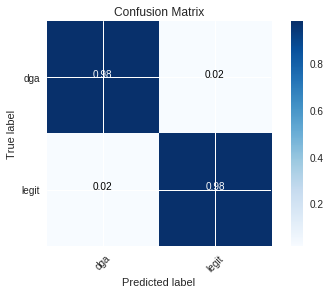

In [27]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
    
cm = cm.astype('float') / cm.sum(axis=1).T[:, np.newaxis]
    
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([1, 0], labels, rotation=45)
plt.yticks([1, 0], labels)
    
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ROC-кривая

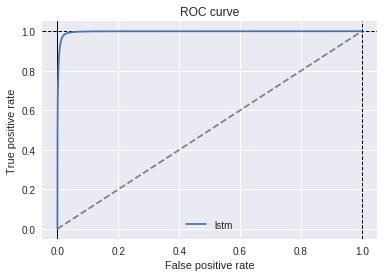

In [28]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label="lstm")
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show() 

Кривая Точность-Полнота (Precision-Recall)

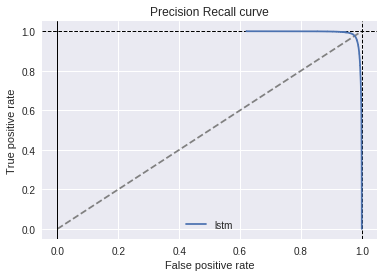

In [29]:
plt.figure()
plt.plot([0, 1], [0, 1], '--', color="grey")
plt.axvline(0, linestyle="-", c="black", lw=1)
plt.axvline(1, linestyle="--", c="black", lw=1)
plt.axhline(1, linestyle="--", c="black", lw=1)
fpr, tpr, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(fpr, tpr, label="lstm")
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.show()